# Titanic: Machine Learning from Disaster (Prediction Score of 0.77990)
This competition intends to use machine learning methods to predict which passengers survived on the Titanic. Since I am new to machine learning, I thought joining this competition would be a great opportunity to learn some new skills and have fun while doing so.

# Loading Data 

In [24]:
# Will be used for data processing
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn

import os

# Models to test data on later
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import CategoricalNB

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Logging

In [25]:
import logging


logger = logging.getLogger('Titanic')
c_handler = logging.StreamHandler()
c_handler.setLevel(logging.INFO)

c_format = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
c_handler.setFormatter(c_format)

logger.addHandler(c_handler)

# Reading Data from External Files

In [26]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
train_data = pd.read_csv('../input/titanic/train.csv')
test_data = pd.read_csv('../input/titanic/test.csv')

# Exploring Data I: Basic Exploration
Let's see what the data looks like.

In [27]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The features that came with the training data (not including 'Survived') are PassengerId, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, and Embarked. These features can be used to predict who survived on the Titanic.

A clarification of feature meaning:
* 'Survived = 0' --> the passenger did not survive,
* 'Survived = 1' --> the passenger survived,
* 'SibSp' --> # of siblings/spouses the passenger had aboard the Titanic,
* 'Parch' --> # of parents/children the passenger had aboard the Titanic,
* 'Embarked' --> the port of embarkation ('Q'=Queenstown, 'S'=Southampton, 'C'=Cherbourg)

Let's examine the shape of the data.

In [1]:
print("Training data shape: %s" % str(train_data.shape))
print("Testing data shape: %s" % str(test_data.shape))

NameError: name 'train_data' is not defined

Our training data set has 891 entries and 12 columns, while our testing data set has 418 entries and 11 columns (missing the 'Survived' column which we will predict). 

# Filling in Missing Data
Now let's examine whether any of the features have null values.

In [2]:
train_data.isnull().sum()

NameError: name 'train_data' is not defined

There are three features with null values: Age, Cabin, and Embarked. Since 'Age' is a numeric feature, We can fill in the null values of Age with its median value. We will first create copies of train_data and test_data to do so to avoid interfering with the previous data. We will also fill the copy of train_data with the median of test_data to allow for better accuracy when predicting later.

In [30]:
train_data_copy = train_data.copy()
test_data_copy = test_data.copy()

train_data_copy.loc[:, 'Age'] = train_data_copy['Age'].fillna(round(train_data['Age'].median()))
test_data_copy.loc[:, 'Age'] = test_data_copy['Age'].fillna(round(train_data['Age'].median()))

Since there are so few null values in 'Embarked', we will artificially fill them in with a 'U'.

In [31]:
train_data_copy.loc[:, 'Embarked'] = train_data_copy.Embarked.fillna(value = 'U')
test_data_copy.loc[:, 'Embarked'] = test_data_copy.Embarked.fillna(value = 'U')

We can also artificially fill in null values of 'Cabin' with a 'U'.

In [32]:
train_data_copy.loc[:, 'Cabin'] = train_data_copy.Cabin.fillna(value = 'U')
test_data_copy.loc[:, 'Cabin'] = test_data_copy.Cabin.fillna(value = 'U')

Let's see how many unique values are in each feature.

In [33]:
train_data.nunique()

2021-08-17 17:41:37,720 - Titanic - INFO - PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64
2021-08-17 17:41:37,720 - Titanic - INFO - PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64


891 unique values for PassengerId and Name means that each passenger has these features specific to them. By themselves, these features likely will not allow for us to predict whether passengers with them survived or not because we are unable to group them by their values. These features have high cardinality, and we generally want to predict on features with low cardinality. 

However, there are still ways to use this data. For example, let's examine 'Cabin.'

In [34]:
train_data_copy.Cabin

2021-08-17 17:41:37,733 - Titanic - INFO - 0         U
1       C85
2         U
3      C123
4         U
       ... 
886       U
887     B42
888       U
889    C148
890       U
Name: Cabin, Length: 891, dtype: object
2021-08-17 17:41:37,733 - Titanic - INFO - 0         U
1       C85
2         U
3      C123
4         U
       ... 
886       U
887     B42
888       U
889    C148
890       U
Name: Cabin, Length: 891, dtype: object


The letter present in each value of 'Cabin' represents the level of the cabin. What makes 'Cabin' have such high cardinality is that after each letter, there is a unique number, likely identifying the specific room in that level. However, by extracting only the level of each cabin, we can extract only the valuable information from 'Cabin' and have 'Cabin' to have fewer unique values, allowing for more pattern detection.

In [35]:
train_data_copy.loc[:, 'Cabin'] = train_data_copy['Cabin'].str.replace('\d+', '').str[-1]
test_data_copy.loc[:, 'Cabin'] = test_data_copy['Cabin'].str.replace('\d+', '').str[-1]

print("Unique values for Cabin: %s" % str(train_data_copy['Cabin'].unique()))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
2021-08-17 17:41:37,759 - Titanic - INFO - Unique values for Cabin: ['U' 'C' 'E' 'G' 'D' 'A' 'B' 'F' 'T']
2021-08-17 17:41:37,759 - Titanic - INFO - Unique values for Cabin: ['U' 'C' 'E' 'G' 'D' 'A' 'B' 'F' 'T']


We can do the same with 'Name'. While there are 891 unique names, each passenger is addressed given a certain title, whether it be 'Sir', 'Ms', or even 'Jonkheer'. We can extract the title from each passenger's name to create a low cardinality version of 'Name'. Only this time, let's create an entirely separate feature for 'Status' and engage in feature engineering.

# Feature Engineering I: The Theory
Feature engineering is a process that entails extracting certain data from one or more features to create an entirely different feature, which may allow for more accurate predictions down the road. We can first see this by creating a new feature called 'Status' based on a passenger's title.

In [36]:
# Gathers only the title from a passenger's name
train_data_copy['Status'] = train_data_copy['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test_data_copy['Status'] = test_data_copy['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

print(train_data_copy)
print("Shape of train_data_copy: ", train_data_copy.shape)
print(train_data_copy.Status.unique())

2021-08-17 17:41:37,777 - Titanic - INFO - ['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer']
2021-08-17 17:41:37,777 - Titanic - INFO - ['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer']


Both train_data_copy and test_data_copy now have a new column that displays the status of an individual. However, we only created the 'Status' feature because of our prediction that an individual's status would impact their survival rate on the Titanic. Let's back up these predictions with science and explore the data, hoping to find new features we can create along the way.

# Data Exploration II: Plotting the Data
Let's examine the relationship between survival rate and certain features by using MatPlotLib and SeaBorn. We'll first examine the features 'Age', 'Pclass', 'SibSp', 'Parch', and 'Fare'.

<Figure size 1152x720 with 0 Axes>

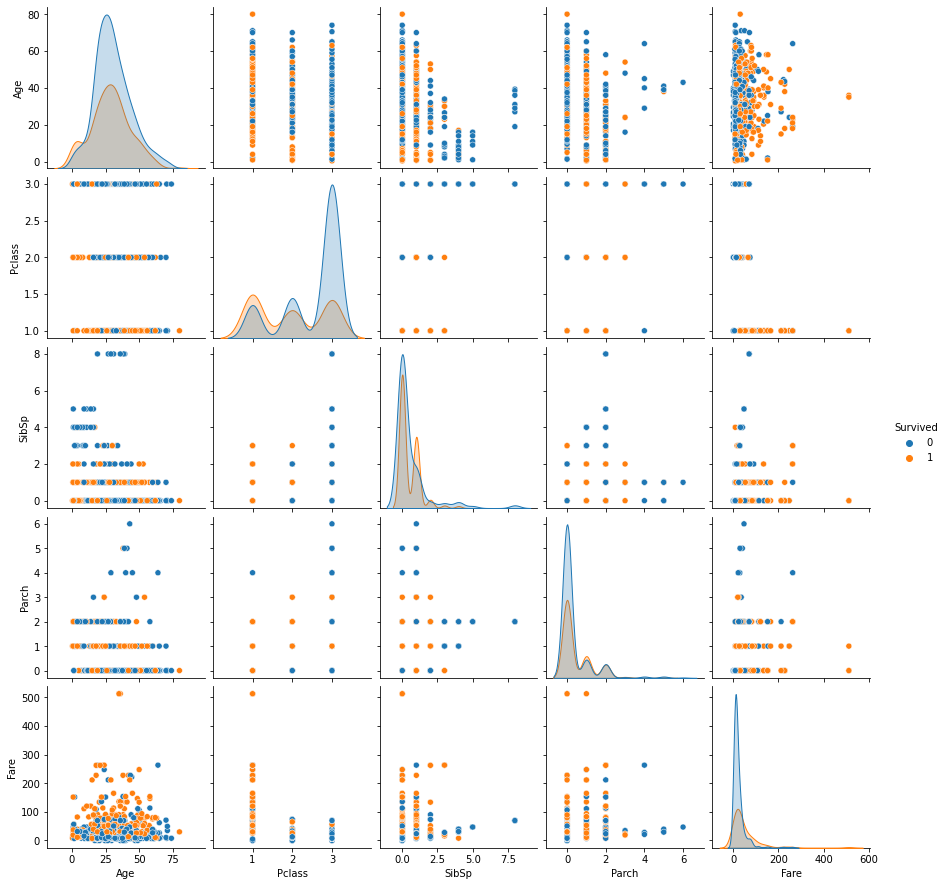

In [37]:
plt.figure(figsize=(16,10)) 
sns.pairplot(train_data[['Age', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Survived']].interpolate(), hue="Survived")
plt.show()

There are some trends that stand out right away. The first is that a vast majority of passengers in Pclass = 3 did not survive. This makes sense from a logistical standpoint, as wealth increasing the probability of survival makes sense. Other observations that support this theory are a.) that most people in Pclass = 1 survived, and b.) those with a fare of less than 200 had a much higher non-survival rate than those with higher fares. 

Additionally, those with a greater number of siblings/spouses/parents/children seemed to have higher rates of survival. We can clump these four variables into one variable called "family" and assume that a large family size must lead to higher rates of survival. And finally, the remaining feature to analyze is Age, and it appears that younger and older ages have higher rates of survival than ages between ~20-40. 

With these observations in mind, let's now analyze them using statistics to see whether we should engineer new features from them.

# Data Exploration III: Statistical Analysis
We will determine whether these trends hold up to real statistics. Thus, we'll first examine the survival rate and non-survival rate across all the data.

In [38]:
survival_rate = train_data.Survived[train_data.Survived == 1].shape[0] / train_data.Survived.shape[0]
non_survival_rate = 1 - survival_rate
print("Survival rate across all data: %.3f" % survival_rate)
print("Non-survival rate across all data: %.3f" % (1 - survival_rate))

2021-08-17 17:41:45,056 - Titanic - INFO - Survival rate across all data: 0.384
2021-08-17 17:41:45,056 - Titanic - INFO - Survival rate across all data: 0.384
2021-08-17 17:41:45,061 - Titanic - INFO - Non-survival rate across all data: 0.616
2021-08-17 17:41:45,061 - Titanic - INFO - Non-survival rate across all data: 0.616


It seems that ~38.4% of passengers survived while ~61.6% of passengers did survive. Let's now look for any survival/non-survival rates that are statistically significant.

Let's first create all of our variables based on trends we want to examine and then calculate the difference between their survival rates and the general survival rate.

In [39]:
# Creating variables that examine the survival rates of certain features
p_class_3 = train_data.loc[train_data.Pclass == 3]['Survived']
p_class_1 = train_data.loc[train_data.Pclass == 1]['Survived']
large_family = train_data.loc[train_data.SibSp + train_data.Parch >= 4]['Survived']
high_fare = train_data.loc[train_data.Fare >= 200]['Survived']
young = train_data.loc[train_data.Age <= 10]['Survived']
old = train_data.loc[train_data.Age >= 70]['Survived']

What about other features? For one, where a passenger embarked may be important. Perhaps certain ports of embarkation had more status than others. The phrase "women and children first" is very significant to our cultural understanding of the Titanic, so women and girls may have had higher rates of survival due to their safety being of higher priority. Or maybe those without a cabin (for there were previously many null values in the feature 'Cabin') were less likely to survive because alarms may have been given to cabins, not to the rest of the ship. 

We can also try to combine certain features. Were young men more likely to survive due to sheer strength alone? What about children with nannies? Did the presence of a mentor make them more likely to be guided to safety? Let's now analyze these features as well.

In [40]:
female = train_data.loc[train_data.Sex == 'female']['Survived']
embarked_S = train_data.loc[train_data.Embarked == 'S']['Survived']
embarked_C = train_data.loc[train_data.Embarked == 'Q']['Survived']
embarked_Q = train_data.loc[train_data.Embarked == 'Q']['Survived']
no_cabin = train_data.loc[train_data.Cabin.isnull()]['Survived']
young_man = train_data.loc[(train_data.Sex == 'male') 
                           & (train_data.Age >= 20) 
                           & (train_data.Age <= 40)]['Survived']
has_nanny = train_data.loc[(train_data.Age <= 15)
                          & train_data.Parch == 0]['Survived']

We will now put all of these features together into one dictionary to analyze them. We'll only print the significant survival rates, when the difference between the survival rate among the general population and the population with that specific feature is greater than or equal to 10%.

In [41]:
""" Putting all the variables into a dictionary
    and assigning them to a string identifier
""" 
analyzed_features = {
    'Third Class passengers': p_class_3,
    'First Class passengers': p_class_1,
    'passengers with a large family': large_family,
    'passengers who paid a high fare': high_fare,
    'young passengers': young,
    'older passengers': old,
    'female passengers': female,
    'passengers who embarked in Southampton': embarked_S,
    'passengers who embarked in Cherbourg': embarked_C,
    'passengers who embarked in Queenstown': embarked_Q,
    'passengers without a cabin': no_cabin,
    'young men': young_man,
    'passengers with a nanny': has_nanny
}

In [42]:
def survival_rates(feature, survivors):
    """Calculates the survival and non-survival rates across various data
    and compares them with the general survival and non-survival rates
    """ 
    assert isinstance(feature, str)
    assert isinstance(survivors, pd.core.series.Series)
    
    if len(survivors):
        feature_survival_rate = sum(survivors) / len(survivors)
        feature_non_survival_rate = 1 - feature_survival_rate
        diff_from_general_pop = survival_rate - feature_survival_rate
        
        # Only returns statistically significant results
        if abs(diff_from_general_pop) >= 0.10:
            logger.info("Survival rate across %s: %.3f" % (feature, feature_survival_rate))
            logger.info("\tDifference from general survival rate: %.3f\n" % (diff_from_general_pop))
            logger.info("Non-survival rate across %s: %.3f" % (feature, feature_non_survival_rate))
            logger.info("\tDifference from general non-survival rate: %.3f\n\n" % 
                  (non_survival_rate - feature_non_survival_rate))
        
    else:
        # In case a group contains no survivors
        logger.debug("No survivors for %s" % feature)
        logger.debug("\tDifference from general survival rate: %.3f\n" % survival_rate)
    return ""

In [43]:
# Runs through the survival_rates function with all the variables
for _ in analyzed_features:
    survival_rates(_, analyzed_features[_])

2021-08-17 17:41:45,142 - Titanic - INFO - Survival rate across Third Class passengers: 0.242
2021-08-17 17:41:45,142 - Titanic - INFO - Survival rate across Third Class passengers: 0.242
2021-08-17 17:41:45,145 - Titanic - INFO - 	Difference from general survival rate: 0.141

2021-08-17 17:41:45,145 - Titanic - INFO - 	Difference from general survival rate: 0.141

2021-08-17 17:41:45,148 - Titanic - INFO - Non-survival rate across Third Class passengers: 0.758
2021-08-17 17:41:45,148 - Titanic - INFO - Non-survival rate across Third Class passengers: 0.758
2021-08-17 17:41:45,152 - Titanic - INFO - 	Difference from general non-survival rate: -0.141


2021-08-17 17:41:45,152 - Titanic - INFO - 	Difference from general non-survival rate: -0.141


2021-08-17 17:41:45,154 - Titanic - INFO - Survival rate across First Class passengers: 0.630
2021-08-17 17:41:45,154 - Titanic - INFO - Survival rate across First Class passengers: 0.630
2021-08-17 17:41:45,156 - Titanic - INFO - 	Difference f

The features we have gathered whose survival rates signficantly differ from that of the general passenger population are passengers in Third/First class, passengers with a large family, passengers who paid a high fare, younger/older passengers, female passengers, and young men. 

Using these features will allow us to generate more accurate predictions. Thus, we'll engineer new features based on these findings.

# Feature Engineering II: The Application
Let's create a function where we create artificial features to add them onto both training and testing data with greater ease. In this function, we'll also assign each title a passenger has to a certain category (or "bucket") based on whether they're considered a commoner, a royal, etc. This will allow for lower cardinality and therefore more accurate predictions.

While initially it may seem like a great idea to only adding the features that had survival rates drastically different from the general survival rate, let's shuffle through more features. This will determine whether a combination of any of those features will generate a greater accuracy than just the features that individually have significant survival rates.

In [1]:
def build_features(df, train_df):
    """ Adds on certain engineered features to a 
        certain dataframe
    """
    
    # Verifies that the parameters are dataframes that are not empty 
    assert isinstance(df, pd.core.frame.DataFrame) and df.shape[0]
    assert isinstance(train_df, pd.core.frame.DataFrame) and train_df.shape[0]
    
    # Adds features which have significant survival rates
    df['ThirdClass'] = df['Pclass'].apply(lambda x: 1 if x == 3 else 0)
    df['FirstClass'] = df['Pclass'].apply(lambda x: 1 if x == 1 else 0)
    df['Young'] = df['Age'].apply(lambda x: 1 if x <= 10 else 0)
    df['FamilySize'] = df['SibSp'] + train_data['Parch'] + 1
    df['HighFare'] = df['Fare'].apply(lambda x: 1 if x >= 200 else 0)
    df['Old'] = df['Age'].apply(lambda x: 1 if x >= 70 else 0)
    df['Female'] = df['Sex'].apply(lambda x: 1 if x == 'female' else 0)
    

    """ Adds passengers onto the 'YoungMan' category
        if they fit the criteria
    """
    df['YoungMan'] = 0
    c1 = (df.Age >= 20) & (df.Age <= 40) & (df.Sex == 'male')
    df.loc[c1, 'YoungMan'] = 1

    
    """ Adds passengers onto the 'HasNanny' category
        if they fit the criteria
    """
    df['HasNanny'] = 0
    c2 = (df.Age <= 15) & (df.Parch == 0)
    df.loc[c2, 'HasNanny'] = 1

    df['Status'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    
    """ Adds passengers onto each separate category in 
        'StatusBucket' if they fit the criteria of that
        category
    """
    df['StatusBucket'] = '?'

    royalty = df['Status'].isin(['Master', 'Lady', 'Sir', 'Countess', 'Jonkheer', 'Don', 'Dona'])
    df.loc[royalty, 'StatusBucket'] = 'Royalty'

    military = df['Status'].isin(['Major', 'Col', 'Capt'])
    df.loc[military, 'StatusBucket'] = 'Military'

    commoners = df['Status'].isin(['Mr', 'Mrs', 'Miss', 'Ms', 'Mme', 'Mlle'])
    df.loc[commoners, 'StatusBucket'] = 'Commoners'

    reverend = df['Status'].isin(['Rev'])
    df.loc[reverend, 'StatusBucket'] = 'Reverend'

    doctor = df['Status'].isin(['Dr'])
    df.loc[doctor, 'StatusBucket'] = 'Doctor'
    
    df['Status_Royalty'] = df['StatusBucket'].apply(lambda x: 1 if x == 'Royalty' else 0)
    df['Status_Commoners'] = df['StatusBucket'].apply(lambda x: 1 if x == 'Commoners' else 0)
    df['Status_Military'] = df['StatusBucket'].apply(lambda x: 1 if x == 'Military' else 0)
    df['Status_Reverend'] = df['StatusBucket'].apply(lambda x: 1 if x == 'Reverend' else 0)
    df['Status_Doctor'] = df['StatusBucket'].apply(lambda x: 1 if x == 'Doctor' else 0)
    
    # Adds features with unassuming survival rates
    df['SecondClass'] = df['Pclass'].apply(lambda x: 1 if x == 2 else 0)
    df['ManySibSp'] = df['SibSp'].apply(lambda x: 1 if x >= 3 else 0)
    df['Single'] = df['FamilySize'].apply(lambda x: 1 if x == 1 else 0)
    df['Male'] = df['Sex'].apply(lambda x: 1 if x == 'male' else 0)
    df['Embarked_S'] = df['Embarked'].apply(lambda x: 1 if x == 'S' else 0)
    df['Embarked_C'] = df['Embarked'].apply(lambda x: 1 if x == 'C' else 0)
    df['Embarked_Q'] = df['Embarked'].apply(lambda x: 1 if x == 'Q' else 0)
    df['NoCabin'] = df['Cabin'].apply(lambda x: 1 if pd.isna(x) else 0)
    
    return df

SyntaxError: invalid syntax (<ipython-input-1-54098d126d93>, line 20)

# Splitting Data into Training and Cross-Validation
Now that we engineered new features, we can start the process of splitting the data into training and cross-validation sets. To do this, we'll use 70% of the data in train_data_copy to train our model on and the other 30% of the data in train_data_copy to test the model and see how it holds up (aka to "cross-validate" the model). To do this, we'll use train_test_split, which randomly splits all the data in train_data_copy into training and testing data.

In [45]:
train_X, val_X, train_y, val_y = train_test_split(train_data_copy.drop(['Survived'], axis = 1), 
                                                             train_data_copy['Survived'], test_size = 0.3,
                                                             stratify = train_data['Survived'])

logger.debug(train_X.shape, val_X.shape, train_y.shape, val_y.shape)

Now that we split our data into training and cval sets, let's cycle through all of the features to see which combination of features will give us the greatest accuracy, which is the metric being tested throughout this competition. Let's also add two additional layers of complexity.


1. Not only will we find the best combination of features that will give us the greatest accuracy, but we will also cycle through various models and see which combination of features and model gives us the greatest possible accuracy.

2. After we find the best features for each model, we'll cycle through many variations of parameters for each model to see which parameters will give us the best score for each model (with its best features).

Let's test the models RandomForestClassifier, DecisionTreeClassifier, LogisticRegression, SGDClassifier, AdaBoostClassifier, and LinearSVC.

# Finding the Best Features for Each Model
Let's cycle through the best features is by looping through each model, starting with all of the features, and then creating lists of all of the features in that iteration with one feature excluded. After gathering the accuracy score of all of the combinations of features, we'll then remove the feature that was excluded in the best mean of that iteration since its inclusion only led to lower means. After we remove that feature, we will cycle through the remaining features and have them undergo the same process, gradually removing features until only 2 remain. After this point, we'll reset our list of features back to the original list and repeat the same process with the next model, continuing until we've cycled through each model.

In [46]:
models = {
    RandomForestClassifier: {'n_estimators': 100, 'max_depth': 5, 'random_state': 42},
    DecisionTreeClassifier: {'max_depth': 5, 'random_state': 42},
    LogisticRegression: {'penalty': 'l1', 'solver': 'liblinear'},
    SGDClassifier: {'loss': 'hinge', 'penalty': 'l2', 'random_state': 42},
    AdaBoostClassifier: {'n_estimators': 100, 'learning_rate': 1, 'random_state': 42},
    LinearSVC: {'penalty': 'l2', 'loss': 'hinge', 'C': 1.0, 'random_state': 42},
}

training = build_features(train_X, train_X)
cval = build_features(val_X, train_X)
model_dict = {}
    
for model in models:
    logger.info("Model %s" % str(model))
    best_mean = 0
    model = model(**models[model])
    
    features = ['Age', 'FirstClass', 'SecondClass', 'ThirdClass', 'HighFare', 'Embarked_C', 
            'Embarked_Q', 'Embarked_S','NoCabin', 'HasNanny', 'Young', 'Single', 'Old', 
            'Female', 'Male', 'FamilySize', 'YoungMan', 'Status_Royalty', 'Status_Military',
           'Status_Commoners', 'Status_Reverend', 'Status_Doctor']
    
    best_mean_in_loop = 0
    best_features = []
    
    while len(features) >= 2:
        worst_feature = None
        logger.debug("Starting with %s features" % features)
        
        for _ in features:
            # Creates a list of all features except one
            temp_list = [i for i in features if i != _]
            
            """ Finds the accuracy score of those features 
                along with its mean and standard deviation
            """ 
            results = cross_validate(model, training[temp_list], train_y, cv = 5, 
                                     scoring = 'accuracy', return_estimator = True, n_jobs = -1)
            current_result = results['test_score'].mean()
            current_std = results['test_score'].std()
        
            # Finds the cross validation accuracy score
            cval_preds = results["estimator"][0].predict(cval[temp_list])
            cval_acc = accuracy_score(val_y, cval_preds)
            
            """ Assigns "best features" to the current features in the loop
                if those features lead to a mean that is greater than the 
                current best one
            """
            if current_result > best_mean:
                best_features = temp_list
                logger.debug("Best result for features %s is %f w/ standard deviation %f\n" % (temp_list, current_result, 
                                                                                  current_std))
                logger.debug("Best features: ", best_features)
                best_mean = current_result
                logger.debug("Cross validation accuracy score = %f\n" % 
                     (cval_acc))
                logger.debug("Difference = %f" % (current_result - cval_acc))
            
            """ Eliminates the worst feature (determined by
                the feature not included in the best mean
                in the loop)
            """
            if current_result > best_mean_in_loop:
                worst_feature = _
                logger.debug("\nWorst feature: %s; %f > %f\n" % (worst_feature, current_result, best_mean_in_loop))
                best_mean_in_loop = current_result  
        
        """ Randomly eliminates the first feature from the list
            if there is no worst feature found
        """
        if not worst_feature:
            worst_feature = features[0]
            logger.debug("No worst feature, therefore removing %s\n" % worst_feature)
            
        logger.debug("Removing feature %s\n\n" % worst_feature)
        features.remove(worst_feature)
        
    model_dict[model] = best_features
    logger.info("Model %s; best features %s" % (model, model_dict[model]))

2021-08-17 17:41:45,339 - Titanic - INFO - Model <class 'sklearn.ensemble._forest.RandomForestClassifier'>
2021-08-17 17:41:45,339 - Titanic - INFO - Model <class 'sklearn.ensemble._forest.RandomForestClassifier'>
2021-08-17 17:44:37,173 - Titanic - INFO - Model RandomForestClassifier(max_depth=5, random_state=42); best features ['Age', 'FirstClass', 'SecondClass', 'ThirdClass', 'HighFare', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'NoCabin', 'HasNanny', 'Young', 'Single', 'Old', 'Female', 'FamilySize', 'YoungMan', 'Status_Royalty', 'Status_Military', 'Status_Commoners', 'Status_Doctor']
2021-08-17 17:44:37,173 - Titanic - INFO - Model RandomForestClassifier(max_depth=5, random_state=42); best features ['Age', 'FirstClass', 'SecondClass', 'ThirdClass', 'HighFare', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'NoCabin', 'HasNanny', 'Young', 'Single', 'Old', 'Female', 'FamilySize', 'YoungMan', 'Status_Royalty', 'Status_Military', 'Status_Commoners', 'Status_Doctor']
2021-08-17 17:44:37,176 

We now have a dictionary (model_dict) that contains the best features for each model.

In [47]:
model_dict

# Finding the Best Parameters for Each Model
Now that we know this information, we can start to cycle through all these models and their corresponding best features to see which parameters suit each model best. To do this, we'll create dictionaries for each model, with the keys representing sample parameters of the model and the values representing possible values for each parameter.

*RandomForestClassifier Parameters*

In [48]:
rf_parameters = {
    'n_estimators': [50, 100, 200, 500, 1000, 2000],
    'max_depth': [2, 3, 5, 10, 15]
}

*LogisticRegression Parameters*

In [49]:
lr_parameters = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.01, 0.05, 0.10, 0.50, 1.0],
    'class_weight': ['balanced', None]
}

*SGDClassifier Parameters*

In [50]:
sgd_parameters = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 1.0],
}

*AdaBoostClassifier Parameters*

In [51]:
ada_parameters = {
    'n_estimators': [50, 100, 200, 500, 1000, 2000]
}

*DecisionTreeClassifier Parameters*

In [52]:
dt_parameters = {
    'max_depth': [2, 3, 5, 10, 15],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced', None]
}

*LinearSVC Parameters*

In [53]:
svc_parameters = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'loss': ['hinge', 'square_hinge'],
    'class_weight': ['balanced', None]
}

To group each model with its corresponding parameters, we'll create a dictionary, where each key represents a model and its corresponding value represents its potential parameters.

In [54]:
model_dict_parameters = {
    RandomForestClassifier: rf_parameters, 
    LogisticRegression: lr_parameters,
    SGDClassifier: sgd_parameters,
    AdaBoostClassifier: ada_parameters,
    DecisionTreeClassifier: dt_parameters,
    LinearSVC: svc_parameters,
}

print(model_dict_parameters)

{<class 'sklearn.ensemble._forest.RandomForestClassifier'>: {'n_estimators': [50, 100, 200, 500, 1000, 2000], 'max_depth': [2, 3, 5, 10, 15]}, <class 'sklearn.linear_model._logistic.LogisticRegression'>: {'penalty': ['l1', 'l2', 'elasticnet'], 'C': [0.01, 0.05, 0.1, 0.5, 1.0], 'class_weight': ['balanced', None]}, <class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'>: {'penalty': ['l1', 'l2', 'elasticnet'], 'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 1.0]}, <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>: {'n_estimators': [50, 100, 200, 500, 1000, 2000]}, <class 'sklearn.tree._classes.DecisionTreeClassifier'>: {'max_depth': [2, 3, 5, 10, 15], 'criterion': ['gini', 'entropy'], 'class_weight': ['balanced', None]}, <class 'sklearn.svm._classes.LinearSVC'>: {'penalty': ['l1', 'l2', 'elasticnet'], 'loss': ['hinge', 'square_hinge'], 'class_weight': ['balanced', None]}}


Now let's create a function using GridSearchCV that will cycle through all of the possible parameters we specified for each model to then return the best score for each model, as well as the parameters required to attain that score. 

In [55]:
def grid_search_cv(model, parameters):
    """ Cycles through a model based on its parameters
        to return the parameters that give the model its
        best accuracy score
    """
    model = model()
    
    assert isinstance(model, sklearn.base.BaseEstimator)
    assert isinstance(parameters, dict)
    
    """ Assures that the correct model will be used based on the 
        model in the dictionary (since model_dict uses models that
        have different parameters from the models in model_dict_parameters)
    """
    new_model_dict = {}
    str_model = str(model)
    str_model = str_model.replace("()", "")
    
    for i in model_dict:
        if str_model in str(i):
            new_model_dict[model] = model_dict[i]
    
    logger.info("Model: %s" % str(model))
    logger.info("Best features: %s" % str(new_model_dict[model]))
    
    clf = GridSearchCV(model, parameters, scoring = 'accuracy', cv = 4, verbose = 1, n_jobs = -1)
    clf.fit(build_features(train_data_copy, train_data_copy)[new_model_dict[model]], 
            build_features(train_data_copy, train_data_copy)['Survived'])
    logger.info("Best score and parameters for %s: %f, %s\n\n" % 
                (str(model), clf.best_score_, str(clf.best_params_)))
    return ""

We can now cycle through this function with all of the model in model_dict_parameters to find the best possible accuracy scores. 

In [56]:
for _ in model_dict_parameters:
    grid_search_cv(_, model_dict_parameters[_])

2021-08-17 17:48:26,334 - Titanic - INFO - Model: RandomForestClassifier()
2021-08-17 17:48:26,334 - Titanic - INFO - Model: RandomForestClassifier()
2021-08-17 17:48:26,337 - Titanic - INFO - Best features: ['Age', 'FirstClass', 'SecondClass', 'ThirdClass', 'HighFare', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'NoCabin', 'HasNanny', 'Young', 'Single', 'Old', 'Female', 'FamilySize', 'YoungMan', 'Status_Royalty', 'Status_Military', 'Status_Commoners', 'Status_Doctor']
2021-08-17 17:48:26,337 - Titanic - INFO - Best features: ['Age', 'FirstClass', 'SecondClass', 'ThirdClass', 'HighFare', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'NoCabin', 'HasNanny', 'Young', 'Single', 'Old', 'Female', 'FamilySize', 'YoungMan', 'Status_Royalty', 'Status_Military', 'Status_Commoners', 'Status_Doctor']


Fitting 4 folds for each of 30 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.1min finished
2021-08-17 17:49:32,987 - Titanic - INFO - Best score and parameters for RandomForestClassifier(): 0.830541, {'max_depth': 5, 'n_estimators': 1000}


2021-08-17 17:49:32,987 - Titanic - INFO - Best score and parameters for RandomForestClassifier(): 0.830541, {'max_depth': 5, 'n_estimators': 1000}


2021-08-17 17:49:32,994 - Titanic - INFO - Model: LogisticRegression()
2021-08-17 17:49:32,994 - Titanic - INFO - Model: LogisticRegression()
2021-08-17 17:49:32,996 - Titanic - INFO - Best features: ['FirstClass', 'SecondClass', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'NoCabin', 'HasNanny', 'Single', 'Old', 'Female', 'Male', 'FamilySize', 'Status_Royalty', 'Status_Military', 'Status_Commoners', 'Status_Reverend', 'Status_Doctor']
2021-08-17 17:49:32,996 - Titanic - INFO - Best featur

Fitting 4 folds for each of 30 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.5s finished
2021-08-17 17:49:33,591 - Titanic - INFO - Best score and parameters for LogisticRegression(): 0.824925, {'C': 1.0, 'class_weight': None, 'penalty': 'l2'}


2021-08-17 17:49:33,591 - Titanic - INFO - Best score and parameters for LogisticRegression(): 0.824925, {'C': 1.0, 'class_weight': None, 'penalty': 'l2'}


2021-08-17 17:49:33,604 - Titanic - INFO - Model: SGDClassifier()
2021-08-17 17:49:33,604 - Titanic - INFO - Model: SGDClassifier()
2021-08-17 17:49:33,612 - Titanic - INFO - Best features: ['Single', 'Old', 'Female', 'Male', 'FamilySize', 'Status_Royalty', 'Status_Reverend', 'Status_Doctor']
2021-08-17 17:49:33,612 - Titanic - INFO - Best features: ['Single', 'Old', 'Female', 'Male', 'FamilySize', 'Status_Royalty', 'Status_Reverend', 'Status_Doctor']
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    0.3s finished
2021-08-17 17:49:34,046 - Titanic - INFO - Best score and parameters for SGDClassifier(): 0.786748, {'alpha': 0.1, 'penalty': 'l1'}


2021-08-17 17:49:34,046 - Titanic - INFO - Best score and parameters for SGDClassifier(): 0.786748, {'alpha': 0.1, 'penalty': 'l1'}


2021-08-17 17:49:34,051 - Titanic - INFO - Model: AdaBoostClassifier()
2021-08-17 17:49:34,051 - Titanic - INFO - Model: AdaBoostClassifier()
2021-08-17 17:49:34,053 - Titanic - INFO - Best features: ['ThirdClass', 'HighFare', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'NoCabin', 'HasNanny', 'Single', 'Old', 'Female', 'Male', 'FamilySize', 'Status_Royalty', 'Status_Military', 'Status_Commoners', 'Status_Reverend', 'Status_Doctor']
2021-08-17 17:49:34,053 - Titanic - INFO - Best features: ['ThirdClass', 'HighFare', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'NoCabin', 'HasNanny', 'Single', 'Old', 'Female', 'Male', 'FamilySize', 'Status_Royalty', 'Status_Mi

Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   14.2s finished
2021-08-17 17:49:48,422 - Titanic - INFO - Best score and parameters for AdaBoostClassifier(): 0.819315, {'n_estimators': 50}


2021-08-17 17:49:48,422 - Titanic - INFO - Best score and parameters for AdaBoostClassifier(): 0.819315, {'n_estimators': 50}


2021-08-17 17:49:48,426 - Titanic - INFO - Model: DecisionTreeClassifier()
2021-08-17 17:49:48,426 - Titanic - INFO - Model: DecisionTreeClassifier()
2021-08-17 17:49:48,428 - Titanic - INFO - Best features: ['SecondClass', 'ThirdClass', 'HighFare', 'Embarked_C', 'Embarked_S', 'NoCabin', 'HasNanny', 'Young', 'Single', 'Old', 'Female', 'Male', 'FamilySize', 'YoungMan', 'Status_Royalty', 'Status_Military', 'Status_Reverend', 'Status_Doctor']
2021-08-17 17:49:48,428 - Titanic - INFO - Best features: ['SecondClass', 'ThirdClass', 'HighFare', 'Embarked_C', 'Embarked_S', 'NoCabin', 'HasNanny', 'Young', 'Single', 'Old', 'Female', 'Male', 'FamilySize', 'YoungMan', 'Status_

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.3s finished
2021-08-17 17:49:48,844 - Titanic - INFO - Best score and parameters for DecisionTreeClassifier(): 0.831662, {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3}


2021-08-17 17:49:48,844 - Titanic - INFO - Best score and parameters for DecisionTreeClassifier(): 0.831662, {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3}


2021-08-17 17:49:48,848 - Titanic - INFO - Model: LinearSVC()
2021-08-17 17:49:48,848 - Titanic - INFO - Model: LinearSVC()
2021-08-17 17:49:48,851 - Titanic - INFO - Best features: ['FirstClass', 'SecondClass', 'ThirdClass', 'HighFare', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'NoCabin', 'HasNanny', 'Young', 'Single', 'Old', 'Female', 'Male', 'FamilySize', 'YoungMan', 'Status_Royalty', 'Status_Military', 'Status_Commoners', 'Status_Reverend', 'Status_Doctor']
2021-08-17 17:49:48,851 - Titanic - INFO - Best features: ['FirstClass', 'SecondClass', 'ThirdClass', 'HighFa

Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  41 out of  48 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    0.2s finished
2021-08-17 17:49:49,140 - Titanic - INFO - Best score and parameters for LinearSVC(): 0.820431, {'class_weight': None, 'loss': 'hinge', 'penalty': 'l2'}


2021-08-17 17:49:49,140 - Titanic - INFO - Best score and parameters for LinearSVC(): 0.820431, {'class_weight': None, 'loss': 'hinge', 'penalty': 'l2'}




Now that we analyzed the best features for each model and have selected their best parameters, let's now choose one of them to submit. Let's choose the model with the best accuracy score, being RandomForestClassifier(max_depth=5, n_estimators=1000) with features ['Age', 'FirstClass', 'SecondClass', 'ThirdClass', 'HighFare', 'Embarked_C', 
            'Embarked_Q', 'Embarked_S','NoCabin', 'HasNanny', 'Young', 'Single', 'Old', 
            'Female', 'Male', 'FamilySize', 'YoungMan', 'Status_Royalty', 'Status_Military',
           'Status_Commoners', 'Status_Reverend', 'Status_Doctor']. Let's also scale FamilySize and Age, then fit our model to the features we selected. We'll use this model to submit our predictions.

In [61]:
# Establishing the best features 
best_features = [
    'Age', 'FirstClass', 'SecondClass', 'ThirdClass', 'HighFare', 'Embarked_C', 
    'Embarked_Q', 'Embarked_S','NoCabin', 'HasNanny', 'Young', 'Single', 'Old', 
    'Female', 'Male', 'FamilySize', 'YoungMan', 'Status_Royalty', 'Status_Military',
    'Status_Commoners', 'Status_Reverend', 'Status_Doctor'
]


"""Calls the function that will add new features 
onto training and cross validation datasets
"""
training = build_features(train_data_copy, train_data_copy)
cval = build_features(test_data_copy, train_data_copy)

# Scales the features
fam_mean = training['FamilySize'].mean()
fam_std = training['FamilySize'].std()

training.loc[:, 'FamilySize'] = training.FamilySize.apply(lambda x: (x - fam_mean) / fam_std)
cval.loc[:, 'FamilySize'] = cval.FamilySize.apply(lambda x: (x - fam_mean) / fam_std)

age_mean = training['Age'].mean()
age_std = training['Age'].std()

training.loc[:, 'Age'] = training.Age.apply(lambda x: (x - age_mean) / age_std)
cval.loc[:, 'Age'] = cval.Age.apply(lambda x: (x - age_mean) / age_std)

In [62]:
""" Establishes the model to be used and fits the model
    on the training data
"""
model = RandomForestClassifier(max_depth=5, n_estimators=1000)
model.fit(training[best_features], train_data.Survived)

# Makes predictions based on the cross-validation data
predictions = model.predict(cval[best_features])

# Submission

In [63]:
test_data_copy['Survived'] = predictions
test_data_submission_columns_final = test_data_copy[['PassengerId', 'Survived']]
test_data_submission_columns_final

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [65]:
submission_file = 'Titanic_Competition_Submission.csv'
test_data_submission_columns_final.to_csv(submission_file,index=False)
print('Saved file: ' + submission_file)

Saved file: Titanic_Competition__Submission.csv


# Conclusion

This entry allowed us to receive a prediction accuracy score of 0.77990. While this score may not be in the top 10% of entries, I still feel proud after having worked on this project for many months. I have submitted more than 20 entries to this competition, with my initial score being 0.76555 after submitting the initial competition files. I have tried out different combinations of features along with different models, and have created many more features along the way. Some entries were worse than others (my lowest accuracy score is 0.71291) and sometimes there was a significant discrepancy between the training accuracy score and the entry's accuracy score (when I had my lowest accuracy score of 0.71291, its corresponding training score was 0.837236, which resulted in me printing the different between the training score and accuracy score in the analyzed_features function).
However, this competition was a solid start for the future of my machine learning studies. I hope to further study machine learning and work to improve my score even more in the future, and to also enter other machine learning competitions to learn more diverse skills within machine learning. For example, this competition dealt with discrete variables, and I would love to experiment with continuous variables in the future. 
I can't wait to learn even more about machine learning throughout my future studies and competitions!